
# Predicting Net Promoter Score (NPS) with NPS verbatims
# Xiyan (Jamie) Wang

## 1. Indroduction

The **Net Promoter Score** is an index ranging from -100 to 100 that measures the willingness of customers to recommend a company’s products or services to others. It is used as a proxy for gauging the customer’s overall satisfaction with a company’s product or service and the customer’s loyalty to the brand. Customers are surveyed on one single question. They are asked to rate on an 11-point scale the likelihood of recommending the company or brand to a friend or colleague.
* ‘Promoters’ answered 9 or 10. They love the company’s products and services. They are the repeat buyers, are the enthusiastic evangelist who recommends the company products and services to other potential buyers. 

* ‘Detractors’ gave a score lower or equal to 6. They are not particularly thrilled by the product or the service. They, with all likelihood, won’t purchase again from the company, could potentially damage the company’s reputation through negative word of mouth.

* ‘Passives’ gave a score of 7 or 8. They are somewhat satisfied but could easily switch to a competitor’s offering if given the opportunity. They probably wouldn’t spread any negative word-of-mouth, but are not enthusiastic enough about your products or services to actually promote them.

Sometimes customers are also surveyed on the “why” behind the score, and their answer to such questions are called **"NPS verbatism"**. Such verbatims can be used to uncover and quantify what the company does well and what it can fix or improve: be a product issue, a support, or a logistics issue.

# 2. Motivations and goals

Currently many company with NPS capability tend to use text analytics techniques to quantify the NPS vervatism. For example, topic modeling has been used frequently to recognize the topics embedded in the verbatims. However, to my knowledge, there exist little practice to use the quantified text data for prediction of any kinds. 

While one can argue that gathering data through survey regularly (i.e. through tracking studies) can provide a company with sufficient awareness of it's custmoter's satisfaction level, it is imperitive to understand that it is also possible to predict NPS scores through predictive modeling using real time text data such as social media reviews. 

In the following excersice, I will use a comparatively small dataset to attemp to set up a predictive model using the verbatims to predict NPS catergories (Promoter/Detractor). 

# 3. Overview of Data

In [5]:
import pandas as pd
import numpy as np
import os
raw = pd.read_csv('C:\\lda python\\Wireline Data for Concept Mining.csv',encoding = "ISO-8859-1")
raw.head()

,Segment,Respondent_Serial,NPS1_1,NPS_Recode,NPS2
0,ISP,62,7,Passive,NaN
1,ISP,64,3,Detractor,NaN
2,ISP,65,10,Promoter,Other options in my community are less desirable.
3,ISP,66,5,Detractor,cost
4,ISP,67,5,Detractor,NaN


Since we are only predicting NPS using Text transcript, and we can not get any information from missing NPS2. We subset data with non-missing NPS.

In [7]:
raw2 = raw.dropna(subset = ['NPS2'])
print("Size of non missing data:", raw2.shape[0])
raw2.head()

Size of non missing data: 54053


,Segment,Respondent_Serial,NPS1_1,NPS_Recode,NPS2
2,ISP,65,10,Promoter,Other options in my community are less desirable.
3,ISP,66,5,Detractor,cost
5,ISP,69,10,Promoter,reliability
6,ISP,70,5,Detractor,too expensive
7,ISP,71,8,Passive,Years ago there was a massive virus attack on ...


Here we check out how balanced the data are in terms of the dependent variable NPS_recode

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
NPS_cat = raw2['NPS_Recode'].value_counts()
color = sns.color_palette()

counts = raw2['NPS_Recode'].value_counts().reset_index()
counts.columns = ['NPS_Recode', 'count']
counts['percentage'] = counts['count']/54053
counts

,NPS_Recode,count,percentage
0,Promoter,18902,0.349694
1,Passive,18008,0.333154
2,Detractor,17143,0.317152


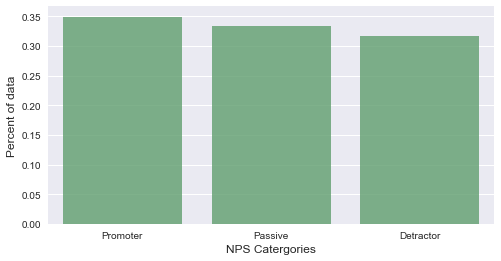

In [9]:
##Interest Level ALONG
plt.figure(figsize=(8,4))
sns.barplot(counts['NPS_Recode'],counts['percentage'], alpha=0.8, color=color[1])
plt.ylabel('Percent of data', fontsize=12)
plt.xlabel('NPS Catergories', fontsize=12)
plt.show()

From the above distribution we can see that around 35% of the data are promoters. Another 33% are Passive and 32% are Detractors.

# 4. Data Cleaning

### 4.1 Tokenize

In [10]:
import re
import warnings
warnings.filterwarnings('ignore')
# Use regular expressions to do a find-and-replace
raw2.loc[:,'NPS2_nopunc'] = raw2.loc[:,'NPS2'].apply(lambda x: re.sub("[^a-zA-Z]"," ",x))
#to lower case and split to list of word 
raw2.loc[:,'NPs2_lower'] = raw2.loc[:,'NPS2_nopunc'].apply(lambda x: x.lower()).apply(lambda x: x.split()) 

### Stopword 

In [12]:
# Remove stop words from "words"
!pip install stop_words
from stop_words import get_stop_words
en_stop = get_stop_words('en')
raw2.loc[:,'NPs2_stopped'] = raw2['NPs2_lower'].apply(lambda x: [item for item in x if item not in en_stop])

  Using cached stop-words-2015.2.23.1.tar.gz
  Running setup.py bdist_wheel for stop-words: started
  Running setup.py bdist_wheel for stop-words: finished with status 'done'
  Stored in directory: C:\Users\xiyan_wang\AppData\Local\pip\Cache\wheels\22\74\80\77275c2f9f2f1d9841b51e169a38985640a10fbd2711d10791
Successfully built stop-words


### Stemming 

In [13]:
from nltk.stem.porter import PorterStemmer
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()
# stem token
raw2.loc[:,'NPS2_stemmed'] = raw2['NPs2_stopped'].apply (lambda x:[p_stemmer.stem(item) for item in x])
raw2.head()

,Segment,Respondent_Serial,NPS1_1,NPS_Recode,NPS2,NPS2_nopunc,NPs2_lower,NPs2_stopped,NPS2_stemmed
2,ISP,65,10,Promoter,Other options in my community are less desirable.,Other options in my community are less desirable,"[other, options, in, my, community, are, less,...","[options, community, less, desirable]","[option, commun, less, desir]"
3,ISP,66,5,Detractor,cost,cost,[cost],[cost],[cost]
5,ISP,69,10,Promoter,reliability,reliability,[reliability],[reliability],[reliabl]
6,ISP,70,5,Detractor,too expensive,too expensive,"[too, expensive]",[expensive],[expens]
7,ISP,71,8,Passive,Years ago there was a massive virus attack on ...,Years ago there was a massive virus attack on ...,"[years, ago, there, was, a, massive, virus, at...","[years, ago, massive, virus, attack, comcast, ...","[year, ago, massiv, viru, attack, comcast, dis..."


In [8]:
### 2-Gram 

# Constructing a document-term matrix (Bag of Word)

After cleaning up the documents, we transform the column of verbatims into a document-term matrix, so that the occurance of each word can be quantified and used for learning process. A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

In [44]:
from gensim import corpora, models
dictionary = corpora.Dictionary(raw2['NPS2_stemmed'])

pandas.core.series.Series

In [10]:
corpus = [dictionary.doc2bow(text) for text in raw2['NPS2_stemmed']]
print "Then convert convert tokenized documents to vectors: %s"% type(corpus)
print(corpus[0])

Then convert convert tokenized documents to vectors: <type 'list'>
[(0, 1), (1, 1), (2, 1), (3, 1)]


# Constructing a tf-idf corpus

In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. 

In [11]:
import gensim
tfidf = models.TfidfModel(corpus) # step 1 -- initialize a model
print "We initialize our TF-IDF transformation tool : %s"%type(tfidf)

# corpus tf-idf
corpus_tfidf = tfidf[corpus]
print corpus_tfidf

We initialize our TF-IDF transformation tool : <class 'gensim.models.tfidfmodel.TfidfModel'>


# Applying the LDA model

The bag-of-words representation with or without a TF-IDF weighting are commonly used in text analytics. It retains a great deal of information, yet it can also be inefficient since many terms may actually represent similar meanings. It can also be confusing since one word can also imply multiple meanings. A bag-of-words representation can also be cumbersome given its high dimentionality. Hence, dimension reduction techniques are usually applied to the document-term matrix to collapse together terms that have the same "Semantics", and to provide a lower-dimensional representation of the documents.

Two forms of dimensional reduction techniques are used here for such analysis, including: 1) Latent semantic indexing, which uses spectral decomposition to identify a lower-dimensional representation of the origianl matrix. 2) Latent dirichlet allocation, which uses a probabilistic model to find the co-occurence patterns of terms that correspond to semantic topics in a collection of documents. 

In [12]:
ldamodel_tfidf = gensim.models.ldamodel.LdaModel(corpus, num_topics=50, id2word = dictionary, passes=20)
ldamodel_bow = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=50, id2word = dictionary, passes=20)

In [13]:
lsamodel_tfidf = gensim.models.lsimodel.LsiModel(corpus, num_topics=50, id2word = dictionary)
lsamodel_bow = gensim.models.lsimodel.LsiModel(corpus_tfidf, num_topics=50, id2word = dictionary)

Extract the document to Topic weight matrix. Each column here have the "loadings " of each document on each topic after dimention reduction.

In [14]:
docTopicProbMat_bow = ldamodel_bow[corpus]
docTopicProbMat_tfidf = ldamodel_tfidf[corpus_tfidf]

In [15]:
docTopicProbMat_bow_lsa = lsamodel_bow[corpus]
docTopicProbMat_tfidf_lsa = lsamodel_tfidf[corpus_tfidf]

# Generate Document Topic Matrix

In [16]:
## bow LDA/LSA
probmatrix_bow = []

for i in docTopicProbMat_bow:
    tmp = [0]*50
    for j in i:
        tmp[j[0]] = j[1]
    probmatrix_bow.append(tmp)

df_bow = pd.DataFrame(probmatrix_bow)

probmatrix_bow_lsa = []

for i in docTopicProbMat_bow_lsa:
    tmp = [0]*50
    for j in i:
        tmp[j[0]] = j[1]
    probmatrix_bow_lsa.append(tmp)

df_bow_lsa = pd.DataFrame(probmatrix_bow_lsa)

In [17]:
## TFIDF LDA/LSA
probmatrix_tfidf = []

for i in docTopicProbMat_tfidf:
    tmp = [0]*50
    for j in i:
        tmp[j[0]] = j[1]
    probmatrix_tfidf.append(tmp)

df_tfidf = pd.DataFrame(probmatrix_tfidf)

In [18]:

probmatrix_tfidf_lsa = []

for i in docTopicProbMat_tfidf_lsa:
    tmp = [0]*50
    for j in i:
        tmp[j[0]] = j[1]
    probmatrix_tfidf_lsa.append(tmp)

df_tfidf_lsa = pd.DataFrame(probmatrix_tfidf_lsa)

In [19]:
print docTopicProbMat_tfidf[1]

[(32, 0.5099999999999999)]


## Attach NPS (label) to the dataset

In [20]:
from sklearn import cross_validation
Y_promoter = (raw2['NPS_Recode'] == "Promoter")
Y_promoter.head()
Y_detractor = (raw2['NPS_Recode'] == "Detractor")
Y_detractor.head()
Y = raw2['NPS_Recode'] 

## Training models for prediction

In this section, we will used our different set-ups to predict NPS category (both promoter and detractor) and find the optimal combination of dimension-reduction + training methods. 

### Promoter - LDA/LSA - BOW 

In [21]:
from sklearn import linear_model,metrics
cv = cross_validation.ShuffleSplit(Y_promoter.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
insample_accuracy_vec = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1., class_weight = 'balanced')
    clf.fit(df_bow.iloc[train], Y_promoter.iloc[train])
    pred = clf.predict(df_bow.iloc[test])
    accuracy = metrics.accuracy_score(Y_promoter.iloc[test],pred)     
    accuracy_vec.append(accuracy)   
    insample_pred = clf.predict(df_bow.iloc[train])
    insample_accuracy = metrics.accuracy_score(Y_promoter.iloc[train],insample_pred)     
    insample_accuracy_vec.append(insample_accuracy) 

In [22]:
accuracy_vec_lsa = []
insample_accuracy_vec_lsa = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1.)  #, class_weight = 'balanced')
    clf.fit(df_bow_lsa.iloc[train], Y_promoter.iloc[train])
    pred_lsa = clf.predict(df_bow_lsa.iloc[test])
    accuracy_lsa = metrics.accuracy_score(Y_promoter.iloc[test],pred)     
    accuracy_vec_lsa.append(accuracy_lsa) 
    insample_pred_lsa = clf.predict(df_bow.iloc[train])
    insample_accuracy_lsa = metrics.accuracy_score(Y_promoter.iloc[train],insample_pred)     
    insample_accuracy_vec_lsa.append(insample_accuracy_lsa) 

In [23]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
insample_accuracy_np = np.array(insample_accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()

accuracy_np_lsa = np.array(accuracy_vec_lsa).mean()  ## get the confidence interval for this accuracy
insample_accuraty_np_lsa = np.array(insample_accuracy_vec_lsa).mean()
accuracy_std_np_lsa = np.array(accuracy_vec_lsa).std()

print "LDA: mean in-sample accuracy of 50 CV is", round(insample_accuracy_np,4)
print "LDA: mean accuracy of 50 CV is", round(accuracy_np,4)
print "LDA: std of 50 CV is", round(accuracy_std_np,4)

print "LSA: mean in-sample accuracy of 50 CV is", round(insample_accuraty_np_lsa,4)
print "LSA: mean accuracy of 50 CV is", round(accuracy_np_lsa,4)
print "LSA: std of 50 CV is", round(accuracy_std_np_lsa,4)

# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

LDA: mean in-sample accuracy of 50 CV is 0.6816
LDA: mean accuracy of 50 CV is 0.6806
LDA: std of 50 CV is 0.0053
LSA: mean in-sample accuracy of 50 CV is 0.5175
LSA: mean accuracy of 50 CV is 0.5146
LSA: std of 50 CV is 0.0234


array([[2319, 1160],
       [ 616, 1311]])

#### Looks like LSA is not a good idea compared to the accuracy of the LDA model. While in-sample accuracy and out-of-sample accuracy are similar and both are around 0.68, we are safe from the plague of over-fitting. For simplicity, the following code would not include in-sample accuracy calculation.

### Promoter - LDA - TFIDF

In [24]:
from sklearn import linear_model,metrics
cv = cross_validation.ShuffleSplit(Y_promoter.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1., class_weight = 'balanced')
    clf.fit(df_tfidf.iloc[train], Y_promoter.iloc[train])
    pred = clf.predict(df_tfidf.iloc[test])
    accuracy = metrics.accuracy_score(Y_promoter.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy)    

In [25]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)

# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.6885
std of 50 CV is 0.0052


array([[2540,  939],
       [ 751, 1176]])

looks like TFIDF is getting similar results for Promoter prediction with LDA dimentsion reduction

## Random Forest

So far we've only used logistics regression, which is a linear classifier. Let's try Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier
cv = cross_validation.ShuffleSplit(Y_promoter.size, n_iter=1, test_size=.1, random_state=0)
accuracy_vec = []
insample_accuracy_vec = []
for k,(train, test) in enumerate(cv):
    rf = RandomForestClassifier()
    rf.fit(df_tfidf.iloc[train],Y_promoter.iloc[train]) 
    pred = rf.predict(df_tfidf.iloc[test])
    accuracy = metrics.accuracy_score(Y_promoter.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy) 

In [27]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)

# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.8356
std of 50 CV is 0.0


array([[3152,  346],
       [ 543, 1365]])

In [28]:
counts =Y_promoter.iloc[test].value_counts().reset_index()
counts

,index,NPS_Recode
0,False,3498
1,True,1908


It seems that reandom forest is giving out a much better prediction

### Detractor - LDA - BOW

In [29]:
from sklearn import linear_model,metrics
cv = cross_validation.ShuffleSplit(Y_detractor.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1., class_weight = 'balanced')
    clf.fit(df_bow.iloc[train], Y_detractor.iloc[train])
    pred = clf.predict(df_bow.iloc[test])
    accuracy = metrics.accuracy_score(Y_detractor.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy)  
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)
# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.6794
std of 50 CV is 0.0073


array([[1436, 2043],
       [1419,  508]])

### Detractor - LDA - TFIDF

In [30]:
from sklearn import linear_model,metrics
cv = cross_validation.ShuffleSplit(Y_detractor.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    clf = linear_model.LogisticRegression(C=1., class_weight = 'balanced')
    clf.fit(df_tfidf.iloc[train], Y_detractor.iloc[train])
    pred = clf.predict(df_tfidf.iloc[test])
    accuracy = metrics.accuracy_score(Y_detractor.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy)  
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)
# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.6635
std of 50 CV is 0.0068


array([[1310, 2169],
       [1352,  575]])

It would seem that LDA prediction for promoter have similar accuracy for BOW and DFIDF set-ups. let's again try the rf model

### Detractor - LDA - Random Forest 

In [31]:
from sklearn.ensemble import RandomForestClassifier
cv = cross_validation.ShuffleSplit(Y_detractor.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    rf = RandomForestClassifier(class_weight = 'balanced')
    rf.fit(df_tfidf.iloc[train],Y_detractor.iloc[train]) 
    pred = rf.predict(df_tfidf.iloc[test])
    accuracy = metrics.accuracy_score(Y_detractor.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy) 

In [32]:
pred

array([False, False, False, ..., False, False,  True], dtype=bool)

In [33]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)
# View confusion matrix
metrics.confusion_matrix(y_true=Y_detractor.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.8783
std of 50 CV is 0.004


array([[3436,  264],
       [ 434, 1272]])

In [34]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][0:10]

print "most important topics in predictions are:", indices
for i in range(len(indices)):
    topics = ldamodel_tfidf.show_topic(i, topn = 8)
    for w in range(5):
        print "topit", i, "word", w, ":", topics[w][0]


most important topics in predictions are: [26 17  1 47  7 21 28 18 22 13]
topit 0 word 0 : channel
topit 0 word 1 : littl
topit 0 word 2 : chang
topit 0 word 3 : far
topit 0 word 4 : complet
topit 1 word 0 : price
topit 1 word 1 : high
topit 1 word 2 : servic
topit 1 word 3 : keep
topit 1 word 4 : go
topit 2 word 0 : provid
topit 2 word 1 : servic
topit 2 word 2 : mediacom
topit 2 word 3 : none
topit 2 word 4 : tech
topit 3 word 0 : will
topit 3 word 1 : come
topit 3 word 2 : even
topit 3 word 3 : day
topit 3 word 4 : wait
topit 4 word 0 : time
topit 4 word 1 : us
topit 4 word 2 : warner
topit 4 word 3 : sinc
topit 4 word 4 : took
topit 5 word 0 : ok
topit 5 word 1 : one
topit 5 word 2 : demand
topit 5 word 3 : hour
topit 5 word 4 : show
topit 6 word 0 : connect
topit 6 word 1 : program
topit 6 word 2 : gener
topit 6 word 3 : overpr
topit 6 word 4 : na
topit 7 word 0 : custom
topit 7 word 1 : servic
topit 7 word 2 : poor
topit 7 word 3 : speak
topit 7 word 4 : support
topit 8 word 0 : 

In [35]:
## Get example documents for each most important topics 
index_maxtopic = df_tfidf.idxmax(axis = 0)
imp_index = index_maxtopic[indices]
print imp_index
print raw['NPS2'][15349]

26    25735
17    41910
1     51958
47     2960
7     13458
21     1548
28     6064
18     1293
22     4966
13    18584
dtype: int64
Everything is for the most part of high quality.


In [36]:

from sklearn.ensemble import RandomForestClassifier
cv = cross_validation.ShuffleSplit(Y.size, n_iter=50, test_size=.1, random_state=0)
accuracy_vec = []
for k,(train, test) in enumerate(cv):
    rf = RandomForestClassifier(class_weight = 'balanced')
    rf.fit(df_tfidf.iloc[train],Y.iloc[train]) 
    pred = rf.predict(df_tfidf.iloc[test])
    accuracy = metrics.accuracy_score(Y.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy) 


In [40]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print "mean accuracy of 50 CV is", round(accuracy_np,4)
print "std of 50 CV is", round(accuracy_std_np,4)
# View confusion matrix

mean accuracy of 50 CV is 0.7555
std of 50 CV is 0.0063


### Bigram Model

In [61]:
from nltk.stem.wordnet import WordNetLemmatizer

docs = raw2['NPS2_stemmed']

# Lemmatize all words in documents.
lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [62]:
from gensim.models import Phrases
from gensim.models import Word2Vec
from nltk.corpus import stopwords

bigram  = Phrases(docs)
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [64]:
from gensim import corpora, models
dictionary_2g = corpora.Dictionary(docs)
dictionary_2g

In [66]:
corpus_2g = [dictionary_2g.doc2bow(text) for text in docs]
print("Then convert convert tokenized documents to vectors: %s"% type(corpus_2g))
print(corpus_2g[0])

Then convert convert tokenized documents to vectors: <class 'list'>
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [67]:
import gensim
tfidf_2g = models.TfidfModel(corpus_2g) # step 1 -- initialize a model
print("We initialize our TF-IDF transformation tool : %s"%type(tfidf_2g))
# corpus tf-idf
corpus_tfidf_2g = tfidf_2g[corpus_2g]

We initialize our TF-IDF transformation tool : <class 'gensim.models.tfidfmodel.TfidfModel'>


In [69]:
ldamodel_tfidf_2g = gensim.models.ldamodel.LdaModel(corpus_tfidf_2g, num_topics=50, id2word = dictionary_2g, passes=20)

In [71]:
docTopicProbMat_tfidf_2g = ldamodel_tfidf_2g[corpus_tfidf_2g]
## TFIDF LDA/LSA
probmatrix_tfidf_2g = []

for i in docTopicProbMat_tfidf_2g:
    tmp = [0]*50
    for j in i:
        tmp[j[0]] = j[1]
    probmatrix_tfidf_2g.append(tmp)

df_tfidf_2g = pd.DataFrame(probmatrix_tfidf_2g)

In [72]:
from sklearn import cross_validation
Y_promoter = (raw2['NPS_Recode'] == "Promoter")
Y_promoter.head()
Y_detractor = (raw2['NPS_Recode'] == "Detractor")
Y_detractor.head()
Y = raw2['NPS_Recode'] 

C:\Users\xiyan_wang\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [77]:
from sklearn.ensemble import RandomForestClassifier
cv = cross_validation.ShuffleSplit(Y_promoter.size, n_iter=1, test_size=.1, random_state=0)
accuracy_vec = []
insample_accuracy_vec = []
for k,(train, test) in enumerate(cv):
    rf = RandomForestClassifier()
    rf.fit(df_tfidf_2g.iloc[train],Y_promoter.iloc[train]) 
    pred = rf.predict(df_tfidf_2g.iloc[test])
    accuracy = metrics.accuracy_score(Y_promoter.iloc[test],pred)      ## fix me
    accuracy_vec.append(accuracy)    

In [78]:
accuracy_np = np.array(accuracy_vec).mean()  ## get the confidence interval for this accuracy
accuracy_std_np = np.array(accuracy_vec).std()
print ("mean accuracy of 50 CV is", round(accuracy_np,4))
print ("std of 50 CV is", round(accuracy_std_np,4))

# View confusion matrix
metrics.confusion_matrix(y_true=Y_promoter.iloc[test],  # True labels
                         y_pred=pred) # Predicted labels

mean accuracy of 50 CV is 0.8352
std of 50 CV is 0.0


array([[3163,  335],
       [ 556, 1352]])